In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
#导入房价数据集
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',header=None,sep='\s+') #空格隔开
df.columns=['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


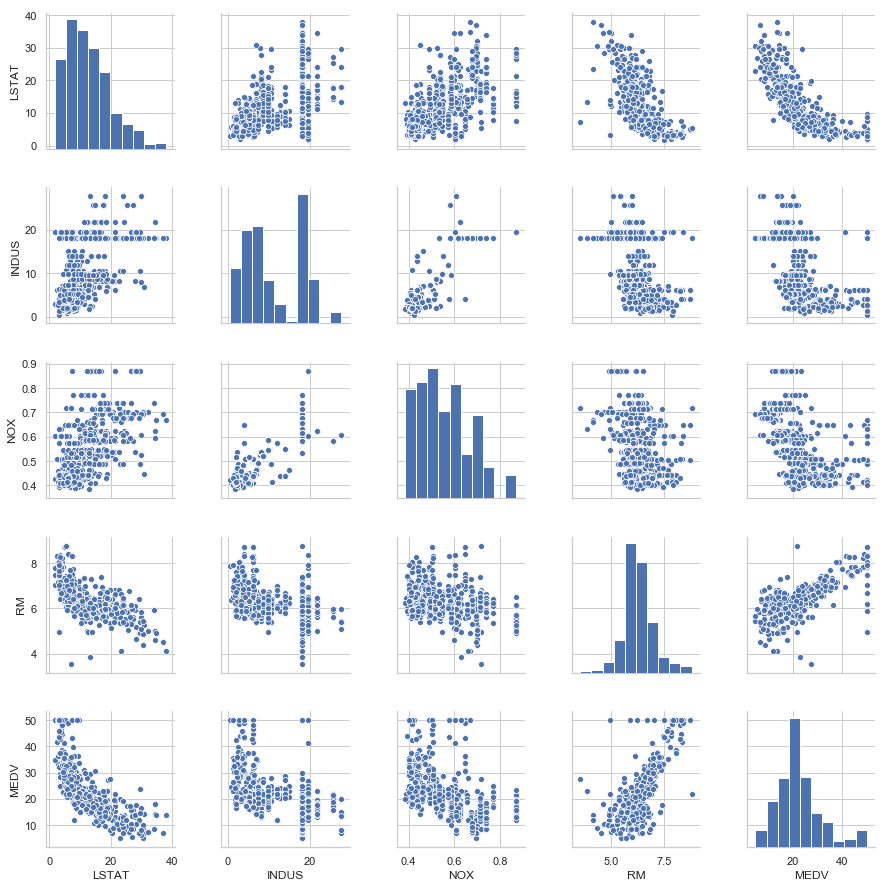

In [5]:
#先挑几个特征进行相关性观察
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',context='notebook')
cols = ['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(df[cols],size=2.5)
plt.tight_layout()
plt.show()

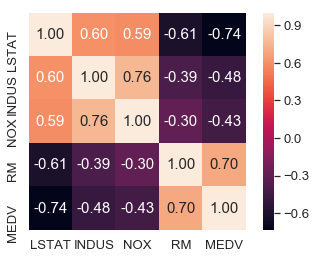

In [14]:
#绘制热力图
import numpy as np
cm = np.corrcoef(df[cols].values.T)  #返回皮尔逊相关系数
sns.set(font_scale=1.2)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':15},yticklabels=cols,xticklabels=cols)
plt.show()

In [15]:
sns.reset_orig()#画板恢复默认设置

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [27]:
#用sklearn查看线性回归系数
from sklearn.linear_model import LinearRegression
X=df[['RM']].values
y=df['MEDV'].values
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)
print('斜率为: %.3f' %slr.coef_[0])
print('截距为: %.3f' %slr.intercept_)

斜率为: 9.102
截距为: -34.671


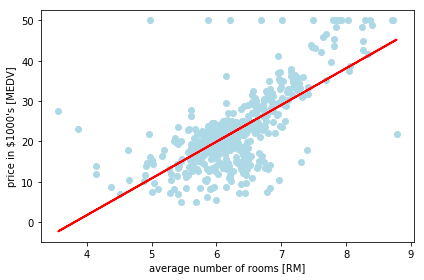

In [29]:
#绘制图像
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='lightblue')
    plt.plot(X,model.predict(X),color='red',linewidth=2)
    return

lin_regplot(X,y,slr)
plt.xlabel('average number of rooms [RM]')
plt.ylabel("price in $1000\'s [MEDV]")
plt.tight_layout()
plt.show()

In [40]:
#直接用方程求出截距和斜率
Xb = np.hstack((np.ones((X.shape[0],1)),X)) #在w矩阵中加入一个1的偏置项
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T,Xb))  #np.linalg.inv计算矩阵的逆
w = np.dot(z,np.dot(Xb.T,y))

print('斜率为：%.3f' %w[1])
print('截距为：%.3f' %w[0])

斜率为：9.102
截距为：-34.671


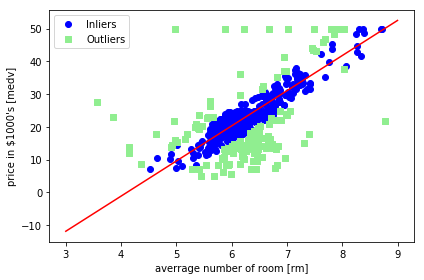

In [46]:
'''
RANSAC(Random Sample Consenus)，它是根据一组包含异常数据的样本数据集，
计算出数据的数学模型参数，得到有效样本数据的算法。使用数据的一个子集(内点,Ran)来进行回归模型的拟合。
'''
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,  #最大迭代次数
                        min_samples=50,  #随机抽取内点最小样本数
                        loss='absolute_loss',
                        residual_threshold=5.0,  #设置预定公差，小于这个值才被加入内点集合
                        random_state=0)
ransac.fit(X,y)
inlier_mask = ransac.inlier_mask_  #内点集合
outlier_mask = np.logical_not(inlier_mask)  #出去内点的集合

line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inliner_mask],c='blue',marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],c='lightgreen',marker='s',label='Outliers')
plt.plot(line_X,line_y_ransac,color='red')
plt.xlabel('averrage number of room [rm]')
plt.ylabel('price in $1000\'s [medv]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
print('斜率为：%.3f'%ransac.estimator_.coef_[0])
print('截距为：%.3f'%ransac.estimator_.intercept_)

斜率为：10.735
截距为：-44.089


In [52]:
#评估线性回归模型性能
#切分数据集
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
X = df.iloc[:,:-10].values
y = df['MEDV'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
slr = LinearRegression()
slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

print('mse train: %.3f,test: %.3f'%(mean_squared_error(y_train,y_train_pred),
                        mean_squared_error(y_test,y_test_pred)))
print('r2 train: %.3f,test: %.3f'%(r2_score(y_train,y_train_pred),
                       r2_score(y_test,y_test_pred)))

mse train: 55.042,test: 60.540
r2 train: 0.351,test: 0.273


In [53]:
#加入正则化，lasso拟合
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)   #正则化系数0.1
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.24168184  0.06836988 -0.4379175   4.98336882]


In [54]:
print('mse train: %.3f,test: %.3f'%(mean_squared_error(y_train,y_train_pred),
                        mean_squared_error(y_test,y_test_pred)))
print('r2 train: %.3f,test: %.3f'%(r2_score(y_train,y_train_pred),
                       r2_score(y_test,y_test_pred)))

mse train: 55.208,test: 60.882
r2 train: 0.349,test: 0.269


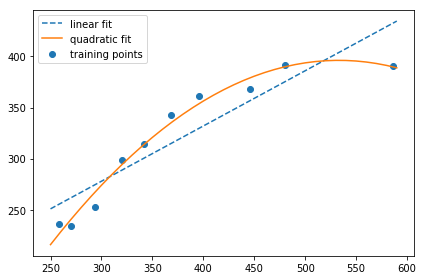

mse train: 569.780,test: 61.330
r2 train: 0.832,test: 0.982


In [64]:
#多项式回归拟合
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

from sklearn.preprocessing import PolynomialFeatures
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) #表示为2元方程拟合
X_quad = quadratic.fit_transform(X)  #对特征进行二次拟合

#单纯线性拟合
lr.fit(X,y)
X_fit = np.arange(250,600,10)[:,np.newaxis]
y_lin_fit = lr.predict(X_fit)

#多项式拟合
pr.fit(X_quad,y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

#绘制图像
plt.scatter(X,y,label='training points')
plt.plot(X_fit,y_lin_fit,label='linear fit',linestyle='--')
plt.plot(X_fit,y_quad_fit,label='quadratic fit')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('mse train: %.3f,test: %.3f'%(mean_squared_error(y,y_lin_pred),
                        mean_squared_error(y,y_quad_pred)))
print('r2 train: %.3f,test: %.3f'%(r2_score(y,y_lin_pred),
                       r2_score(y,y_quad_pred)))

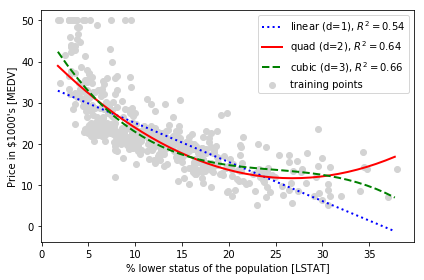

In [67]:
#房价数据集多项式拟合
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

#构建二次和三次项特征
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(),X.max(),1)[:,np.newaxis]

#拟合线性特征
regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y,regr.predict(X))

#拟合二次
regr = regr.fit(X_quad,y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y,regr.predict(X_quad))

#拟合三次项
regr = regr.fit(X_cubic,y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y,regr.predict(X_cubic))

#绘图
plt.scatter(X,y,label='training points',color='lightgray')

plt.plot(X_fit,y_lin_fit,label='linear (d=1), $R^2=%.2f$' % linear_r2,color='blue',lw=2,linestyle=':')  #lw表示线宽为2
plt.plot(X_fit,y_quad_fit,label='quad (d=2), $R^2=%.2f$' % quadratic_r2,color='red',lw=2,linestyle='-')
plt.plot(X_fit,y_cubic_fit,label='cubic (d=3), $R^2=%.2f$' % cubic_r2,color='green',lw=2,linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

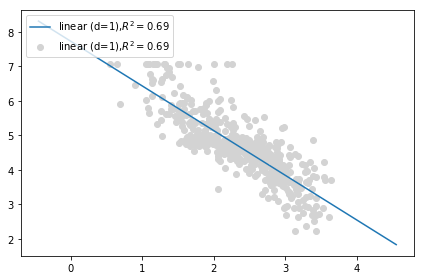

In [71]:
#对特征进行处理后进行多项式拟合
X = df[['LSTAT']].values
y = df['MEDV'].values
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1,X_log.max()+1,1)[:,np.newaxis]

#线性拟合
regr = regr.fit(X_log,y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt,regr.predict(X_log))

#绘图
plt.scatter(X_log,y_sqrt,label='linear (d=1),$R^2=%.2f$'%linear_r2,color='lightgray')
plt.plot(X_fit,y_lin_fit,label='linear (d=1),$R^2=%.2f$'%linear_r2)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

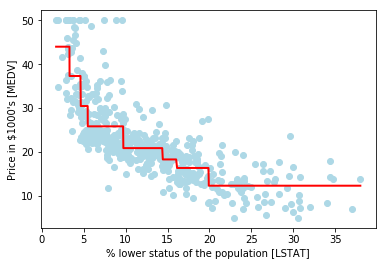

In [73]:
#回归树拟合
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
 
sort_idx = X.flatten().argsort()  #argsort()从小到大排序，并返回序对应的原索引

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

MSE train: 1.641, test: 11.056
R^2 train: 0.979, test: 0.878


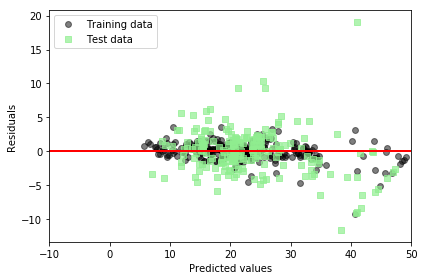

In [74]:
#随机森林拟合
X = df.iloc[:, :-1].values  
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#绘图
plt.scatter(y_train_pred,  
            y_train_pred - y_train,   #绘制误差分布
            c='black', 
            marker='o', 
            s=35,  #标识大小
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red') #绘制水平线，从-10到50
plt.xlim([-10, 50])
plt.tight_layout()